In [23]:
import sys
import os
import itertools
import numpy as np
import torch as tr
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('talk')
import pprint

import multiprocessing as mp
import concurrent
import time
tstamp = time.perf_counter_ns()

from utils import *

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# build pub

- minimal PWM5 task:
    - 5 stimuli (ABCDE) 
    - 3 trials of trlen 3
    - with violation timeout 
    

In [24]:
def seed_exp(seed,args):
  """ loss [(value, policy),neps] """
  # setup
  np.random.seed(seed)
  neps = args['train']['neps']
  # task and agent definition
  agent = ActorCritic(**args['agent'])
  task = PWMTaskFR(**args['task'])
  # init loop vars
  reward = -np.ones(neps)
  loss = -np.ones([2,neps])
  pism = -np.ones([3,neps])
  trcount = -np.ones(neps)
  L = []
  # loop over epochs
  for epoch in range(neps):
    epoch_data = run_epoch_FR(agent,task,pub=True)
    epoch_data = process_epdata(epoch_data)
    update_data = agent.update(epoch_data)
    trcount[epoch] = np.sum(epoch_data['ttype'])
    reward[epoch] = np.sum(epoch_data['reward'])/task.ntrials
    loss[:,epoch] = list(update_data.values())
  data = {'loss':loss,'reward':reward,'trcount':trcount}
  return data

In [31]:
# common setup
ns,neps = 1,1
args = {
  'train':{
    'neps':neps
  },
  'agent':{
    'gamma':1.0,
    'learnrate':0.005,
    'lweight':None # gridsearching
  },
  'task':{
    'stimset':'pwm5',
    'epoch_len':9, ## 3 trials len 3 each
    'trlen':3
  }
}
# loop vars
lwL = [2] ## 
loss = np.zeros([len(lwL),ns,2,neps])
reward = np.zeros([len(lwL),ns,neps])
trcount = np.zeros([len(lwL),ns,neps])
# gridsearch loss weight
for idx in range(len(lwL)):
  print('c')
  # setup and run exp
  args['agent']['lweight'] = lwL[idx]
  dataL = exp_mp(seed_exp,nseeds=ns,gsvar=args)
  # unpack data
  loss[idx] = np.array([d['loss'] for d in dataL])
  reward[idx] = np.array([d['reward'] for d in dataL])
  trcount[idx] = np.array([d['trcount'] for d in dataL])

# reshape data for plotting
vloss = loss[:,:,0,:]
ploss = loss[:,:,1,:]
data = np.array([reward,vloss,ploss])
data.shape # [{R/vL/pL},cond,seeds,epochs]

c
tr 0
tensor([[ 0.0301, -0.0802, -0.0351,  0.0255, -0.0372],
        [ 0.0369, -0.1013, -0.0395,  0.0268, -0.0522],
        [ 0.0060, -0.1502,  0.0132,  0.0430, -0.0220]],
       grad_fn=<SliceBackward>)
tr 3
tensor([[ 0.0208, -0.0553, -0.0139,  0.0190, -0.0464],
        [ 0.0313, -0.0862, -0.0184,  0.0198, -0.0512],
        [ 0.0366, -0.1036, -0.0192,  0.0172, -0.0453]],
       grad_fn=<SliceBackward>)
tr 6
tensor([[ 0.0107, -0.0524, -0.0227, -0.0029, -0.0824],
        [ 0.0326, -0.0792, -0.0228,  0.0107, -0.0612],
        [ 0.0062, -0.1368,  0.0270,  0.0324, -0.0223]],
       grad_fn=<SliceBackward>)
pub
dict_keys(['state', 'obs', 'action', 'reward', 'vhat', 'distr', 'ttype', 'logpr_actions', 'pism'])
[array([0., 0., 2.]), array([0., 0., 0.]), array([0., 0., 1.])]
[tensor([[-1.0652],
        [-1.1258],
        [-1.1052]], grad_fn=<SqueezeBackward1>), tensor([[-1.1272],
        [-1.1346],
        [-1.1423]], grad_fn=<SqueezeBackward1>), tensor([[-1.1162],
        [-1.1367],
        [

(3, 1, 1, 1)

### plots

(0.0, 1.0)

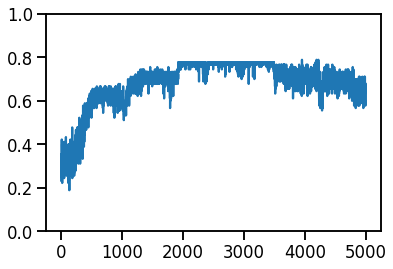

In [4]:
# reward
for r in reward.mean(1):
  plt.plot(r.reshape(-1,10).mean(-1))
plt.ylim(0,1)

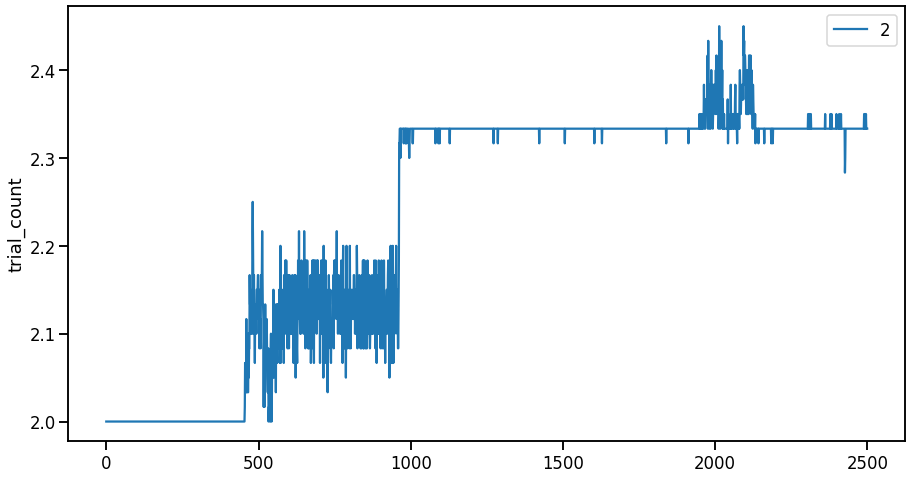

In [5]:
plt.figure(figsize=(15,8))
# trial count
for idx in range(len(lwL)): # loop over conds
  plt.plot(trcount[idx].mean(0).reshape(-1,20).mean(-1),
          label=lwL[idx])
plt.ylabel('trial_count')
plt.legend()
plt.savefig('figures/trial_count-pwm5eplen%i-REINFORCE-lrate_%.4f-%iseeds-gridsearch_lossweight-%i.png'%(
  args['task']['epoch_len'],args['agent']['learnrate'],ns,tstamp)
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

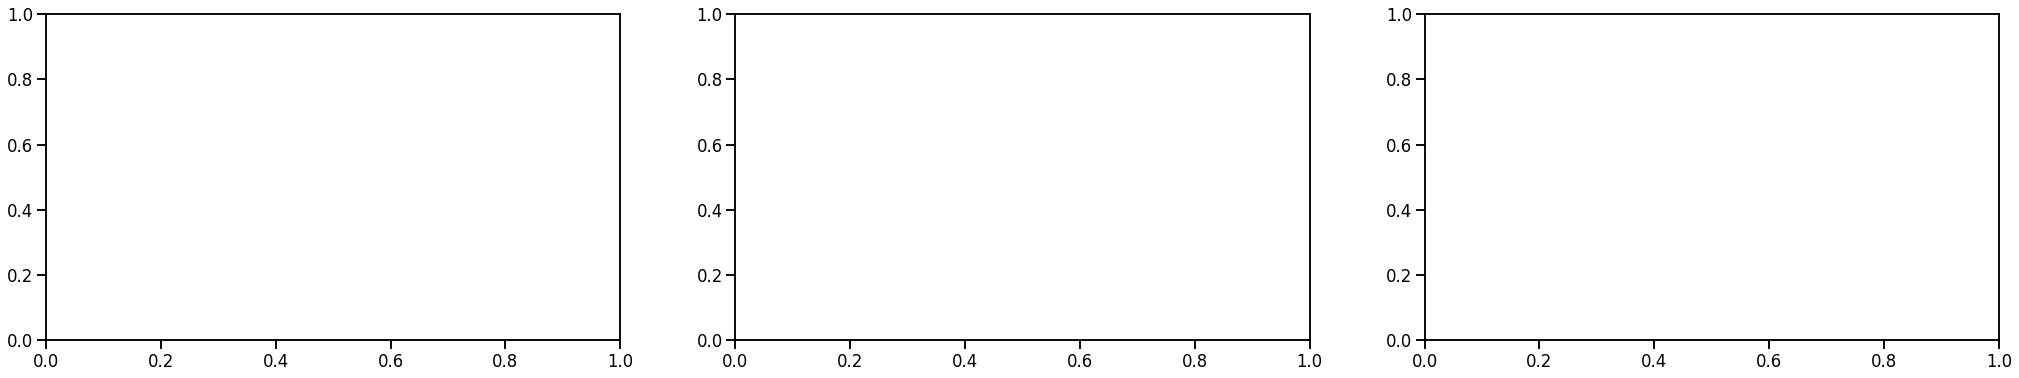

In [6]:
def plt_metrics(data,condL,mawin=10):
  """ plot data{reward,vloss,ploss}
  input shapes [num_cond,seed,epochs]
  moving average to smooth plots
  condL labels conds along num_cond
  """
  _,ncond,nseeds,nepochs = data.shape
  mdata = data.mean(2)
  sdata = data.std(2)/np.sqrt(nseeds)
  # plot setup
  f,axar = plt.subplots(ncond,3,figsize=(35,6*ncond),sharex=True)
  axar[0,0].set_title('reward')
  axar[0,1].set_title('value loss')
  axar[0,2].set_title('policy loss')
  # loop over axes
  for ci in range(ncond):
    axa = axar[ci]
    axa[0].set_ylabel(condL[ci])
    axa[0].set_ylim(0.2,1)
    for ii in range(3):
      ax = axa[ii]
      # moving average
      M = mdata[ii,ci].reshape(-1,mawin).mean(-1)
      S = sdata[ii,ci].reshape(-1,mawin).mean(-1)
      ax.plot(M)
      ax.fill_between(range(len(M)),M-S,M+S,alpha=0.2)

  return None

plt_metrics(data,lwL,mawin=10)

plt.savefig('figures/loss+reward-pwm5eplen%i-REINFORCE-lrate_%.4f-%iseeds-gridsearch_lossweight-%i.png'%(
  args['task']['epoch_len'],args['agent']['learnrate'],ns,tstamp)
)